## Visualizing the dataset

In [1]:
import pyphysics as phys
import uproot
import awkward as ak
import hist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### What should we expect from the energy-loss profile on gas?


In [2]:
parts = ["p", "d", "t"]
data = ak.concatenate([
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree").arrays(), "p", "label"),
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree").arrays(), "d", "label"),
    ak.with_field(uproot.open("./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree").arrays(), "t", "label"),
])

In [14]:
## Kinematics plot
hkins = {}
for part in parts:
    hkin = hist.Hist.new.Reg(300, 0, 80, label="theta [deg]").Reg(300, 0, 80, label="Elab [MeV]").Double()
    gated = data[data.label == part]
    hkin.fill(gated.theta3, gated.T3)
    hkins[part] = hkin


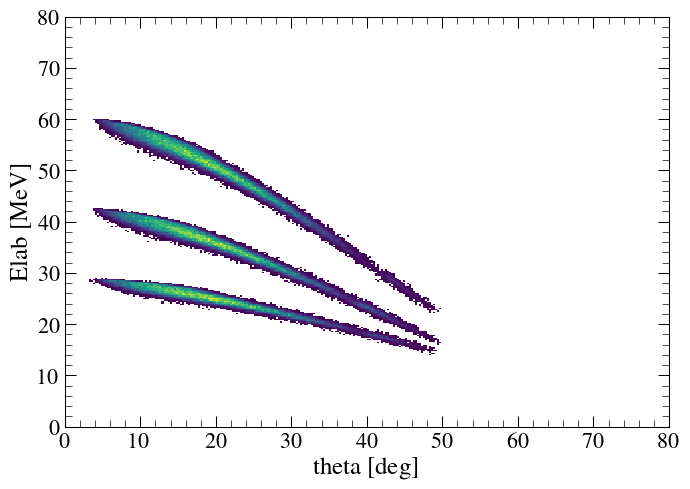

In [15]:
fig, ax = plt.subplots(1, 1)
for i, p in enumerate(parts):
    hkins[p].plot(ax=ax, cmin=1, cbar=None)
fig.tight_layout()

In [4]:
## Gate on events with same initial conditions
Tini = 25
theta3 = 40
RPx = 220
offset = 5

gate = (
    (data.T3 >= Tini - offset) & (data.T3 <= Tini + offset) &
    (data.theta3 >= theta3 - offset) & (data.theta3 <= theta3 + offset) &
    (data.RPx >= RPx - offset) & (data.RPx <= RPx + offset)
)

gated = data[gate]

counts = np.unique(gated.label, return_counts=True)
counts

<Array [['d', 'p', 't'], [283, ..., 2]] type='2 * var * union[string, int64]'>

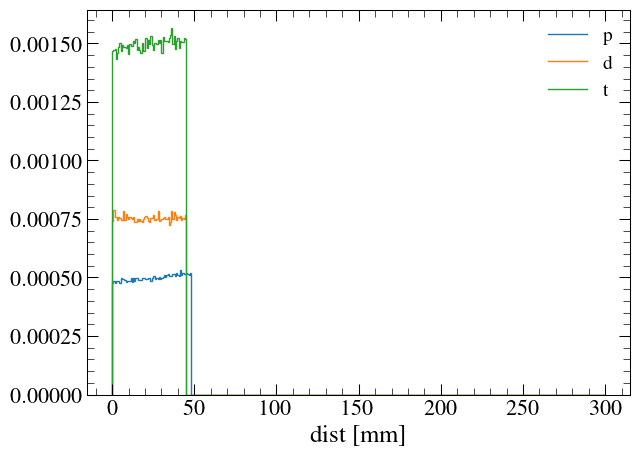

In [5]:
fig, ax = plt.subplots(1, 1)
for p in ["p", "d", "t"]:
    if not len(gated[gated.label == p]):
        continue
    proj = gated[gated.label == p][1].profy
    h = hist.Hist.new.Reg(400, 0, 300, label="dist [mm]").Double()
    h[...] = proj
    h.plot(histtype="step", yerr=False,label=p)
ax.legend()